In [27]:
"""Figure core creation: Fig3

Formatting of the figures may not be identical to the paper, but they contain the same data points.
"""
# pylint: disable=import-error, redefined-outer-name, use-dict-literal, too-many-lines, too-many-branches, consider-using-f-string

'Figure core creation: Fig3\n\nFormatting of the figures may not be identical to the paper, but they contain the same data points.\n'

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [ ]:
from __future__ import annotations

import re
from pathlib import Path
from typing import Dict, List

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import upsetplot
from IPython.display import display

from epi_ml.utils.notebooks.paper.paper_utilities import (
    ASSAY,
    ASSAY_ORDER,
    LIFE_STAGE,
    SEX,
    IHECColorMap,
    MetadataHandler,
    SplitResultsHandler,
    merge_life_stages,
)

In [30]:
CANCER = "harmonized_sample_cancer_high"
CORE_ASSAYS = ASSAY_ORDER[0:7]

### General paths setup

In [31]:
base_dir = Path.home() / "Projects/epiclass/output/paper"
paper_dir = base_dir
if not paper_dir.exists():
    raise FileNotFoundError(f"Directory {paper_dir} does not exist.")

base_data_dir = base_dir / "data"
base_fig_dir = base_dir / "figures"

In [32]:
IHECColorMap = IHECColorMap(base_fig_dir)
assay_colors = IHECColorMap.assay_color_map
cell_type_colors = IHECColorMap.cell_type_color_map
sex_colors = IHECColorMap.sex_color_map

In [33]:
split_results_handler = SplitResultsHandler()

metadata_handler = MetadataHandler(paper_dir)
metadata_v2 = metadata_handler.load_metadata("v2")
metadata_v2_df = metadata_handler.load_metadata_df("v2")

### ChIP-Atlas predictions file `CA_metadata_4DB+all_pred.20240606_mod3.0.tsv`

See README for meaning of mod3.0.

In [ ]:
base_pred_dir = base_data_dir / "training_results" / "predictions"
if not base_pred_dir.exists():
    raise FileNotFoundError(f"Directory {base_pred_dir} does not exist.")

ca_preds_dir = base_pred_dir / "C-A"
ca_preds_path = ca_preds_dir / ASSAY / "CA_metadata_4DB+all_pred.20240606_mod3.0.tsv"
ca_preds_df = pd.read_csv(ca_preds_path, sep="\t", low_memory=False)

print(f"ChIP-Atlas: {ca_preds_df.shape[0]} total files")

ChIP-Atlas: 48669 total files


In [35]:
DB_COLS = ["GEO_mod", "C-A", "Cistrome", "NGS_mod"]

In [36]:
print("ChIP-Atlas - Available model predictions")
for col in ca_preds_df.columns:
    if "Max_pred" in col:
        model_task = col.split("_")[-1]
        print(model_task)

ChIP-Atlas - Available model predictions
assay7
assay11
assay13
cancer
disease
donorlife
project
sex
assay
biomat
paired
sex.1
disease.1


In [37]:
if ca_preds_df[ca_preds_df.isin(["h3.3k27m"])].notna().sum().sum() != 0:
    raise ValueError("h3.3k27m is still present in the dataframe")

Predictions from following models and more:
| Metadata category|   Nb classes |     Experiment Key (comet.com)      | Nb Files | Training Size |
|------------------|--------------|------------------------------|----------|---------------|
| assay_epiclass   |     7      | 69488630801b4a05a53b5d9e572f0aaa       | 16788    | 34413 |
| assay_epiclass   |     11      | 0f8e5eb996114868a17057bebe64f87c      | 20922    | 46128 |
| assay_epiclass   |     13      | dd3710b73c0341af85a17ce1998362d0      | 24989    | 116550|
| harmonized_donor_sex | 3    | 4b908b83e0ec45c3ab991e65aa27af0c | 18299    | 28078  |
| harmonized_donor_life_stage | 5    | 91214ed0b1664395b1826dc69a495ed4 | 15372    | 66372  |
| harmonized_sample_cancer_high | 2    | 15da476b92f140eab818ece369248f4c | 20922    | 34491  |

The training size is higher than the number of files because of random oversampling of minority classes up to approx. majority size.

Classes:

- assay 7c: 6 h3k* histone marks + input
- assay 11c: assay7c + rna_seq + mrna_seq + wgbs_standard + wgbs_pbat
- assay 13c: assay11c + encode non-core + encode CTCF
- harmonized_donor_sex: male, female, mixed
- harmonized_donor_life_stage: adult, child, newborn, fetal, embryonic
- harmonized_sample_cancer_high (modification of harmonized_sample_disease_high): cancer, non-cancer (healthy/None+disease)

Training metadata: Approximately `IHEC_metadata_harmonization.v1.1.extended.csv` + encode non-core (`hg38_2023-epiatlas-dfreeze_v2.1_w_encode_noncore_2.json`).
See `data/metadata/README.md` for metadata details, and `training_metadata_vs_official.json` for exact difference of our training data with v1.0 and v1.1.

### ENCODE predictions file `encode_predictions_augmented_merged.csv`

See `models.list` in `encode_preds_dir` for comet.com experiment keys.
Same models as ChIP-Atlas predictions. The assay_epiclass model is the 7c one.  
Additonally, the `harmonized_sample_ontology_intermediate` model was used on a subset of files with known EpiATLAS sample ontologies.

| Metadata category|   Nb classes |     Experiment Key (comet.com)      | Nb Files | Training Size |
|------------------|--------------|------------------------------|----------|---------------|
| harmonized_sample_ontology_intermediate   |     16      | bb66b72ae83645d587e50b34aebb39c3      | 16379    | 49054|\

Metadata for ENCODE predictions created using:  
FILE + EXPERIMENT + BIOSAMPLE accessions, starting from filenames.  
See `src/python/epi_ml/utils/notebooks/paper/encode_metadata_creation.ipynb`  
Final metadata file: `encode_full_metadata_2025-02_no_revoked.json`  

In [84]:
encode_meta_dir = base_data_dir / "metadata" / "encode"

In [85]:
encode_preds_dir = base_pred_dir / "encode"
encode_preds_path = (
    encode_preds_dir / "complete_encode_predictions_augmented_2025-02_metadata.csv"
)
encode_preds_df = pd.read_csv(encode_preds_path, sep=",", low_memory=False)
print(f"ENCODE: {encode_preds_df.shape[0]} total files")

ENCODE: 11409 total files


In [86]:
encode_preds_df["in_epiatlas"].value_counts(dropna=False)

False    8679
True     2712
NaN        18
Name: in_epiatlas, dtype: int64

In [87]:
encode_preds_df = encode_preds_df[encode_preds_df["in_epiatlas"].astype(str) == "False"]
print(f"ENCODE: {encode_preds_df.shape[0]} total files with no EpiAtlas overlap")

ENCODE: 8679 total files with no EpiAtlas overlap


In [89]:
for col in encode_preds_df.columns:
    if LIFE_STAGE in col:
        print(col)

True class (harmonized_donor_life_stage)
Predicted class (harmonized_donor_life_stage)
Max pred (harmonized_donor_life_stage)
2nd pred class (harmonized_donor_life_stage)
1rst/2nd prob diff (harmonized_donor_life_stage)
1rst/2nd prob ratio (harmonized_donor_life_stage)
harmonized_donor_life_stage


## Fig 3

Removing ChIP-Atlas experiment overlap with EpiATLAS

In [42]:
print(f"ChIP-Atlas: Initial {ca_preds_df.shape[0]} files")
no_epiatlas_df = ca_preds_df[ca_preds_df["is_EpiAtlas_EpiRR"] == "0"]

diff = ca_preds_df.shape[0] - no_epiatlas_df.shape[0]
print(f"ChIP-Atlas: {diff} files with EpiAtlas EpiRR removed")
print(f"ChIP-Atlas: {no_epiatlas_df.shape[0]} files without EpiAtlas EpiRR")

ChIP-Atlas: Initial 48669 files
ChIP-Atlas: 1047 files with EpiAtlas EpiRR removed
ChIP-Atlas: 47622 files without EpiAtlas EpiRR


Ignoring non-core consensus files.

In [43]:
non_core_labels = ["non-core", "CTCF"]
ca_core7_df = no_epiatlas_df[
    ~no_epiatlas_df["manual_target_consensus"].isin((non_core_labels))
]

diff = no_epiatlas_df.shape[0] - ca_core7_df.shape[0]
print(f"ChIP-Atlas: {diff} files with non-core consensus removed")
print(f"ChIP-Atlas: {ca_core7_df.shape[0]} files with core consensus")

ChIP-Atlas: 918 files with non-core consensus removed
ChIP-Atlas: 46704 files with core consensus


In [44]:
ca_core7_df["manual_target_consensus"].value_counts()

input           17930
h3k27ac         11169
h3k4me3          6328
h3k27me3         4195
h3k4me1          3034
h3k9me3          2102
h3k36me3         1421
no_consensus      525
Name: manual_target_consensus, dtype: int64

### Fig 3A - ChIP-Atlas assay (7classes) prediction

#### High-confidence predictions

In [45]:
total_N = ca_core7_df.shape[0]
high_confidence_pred_df = ca_core7_df[ca_core7_df["Max_pred_assay7"] >= 0.6]

high_confidence_N = high_confidence_pred_df.shape[0]
N_percent = high_confidence_N / total_N
display(
    f"ChIP-Atlas: {high_confidence_N}/{total_N} files ({high_confidence_N/total_N:.2%}) with high confidence assay prediction"
)

'ChIP-Atlas: 41796/46704 files (89.49%) with high confidence assay prediction'

#### Match between manual target consensus and MLP prediction

In [46]:
total_N = high_confidence_pred_df.shape[0]

match_rule = (
    high_confidence_pred_df["manual_target_consensus"]
    == high_confidence_pred_df["Predicted_class_assay7"]
)
match_df = high_confidence_pred_df[match_rule]
mismatch_df = high_confidence_pred_df[~match_rule]

agreement_N = match_df.shape[0]

print(
    f"ChIP-Atlas: {agreement_N}/{total_N} files ({agreement_N / total_N:.2%}) with agreement between consensus and predicted assay"
)

ChIP-Atlas: 39532/41796 files (94.58%) with agreement between consensus and predicted assay


#### Mismatch breakdown

In [47]:
total_mismatch = mismatch_df.shape[0]
input_rule = mismatch_df["Predicted_class_assay7"] == "input"
input_pred_N = input_rule.sum()

print(
    f"ChIP-Atlas: {input_pred_N}/{total_mismatch} files ({input_pred_N / total_mismatch:.2%}) with mismatch predicted as input"
)
print(
    f"ChIP-Atlas: {total_mismatch-input_pred_N}/{total_mismatch} files ({(total_mismatch-input_pred_N) / total_mismatch:.2%}) potential mislabels"
)
display(mismatch_df[~input_rule]["core7_DBs_consensus"].value_counts(dropna=False))

ChIP-Atlas: 1525/2264 files (67.36%) with mismatch predicted as input
ChIP-Atlas: 739/2264 files (32.64%) potential mislabels


Identical                       468
Different                       158
Ignored - Potential non-core     64
1 source                         49
Name: core7_DBs_consensus, dtype: int64

### Fig 3B-C-D - ChIP-Atlas donor sex, cancer and life stage predictions

In [48]:
new_ca_meta_path = ca_preds_path.parent / "CA_metadata_FW_20240917.tsv"
new_ca_meta_df = pd.read_csv(new_ca_meta_path, sep="\t", low_memory=False)

new_ca_meta_df["True_class_FW_donorlife"] = new_ca_meta_df["True_class_FW_age"]
new_cols = ["True_class_FW_cancer", "True_class_FW_sex", "True_class_FW_donorlife"]
new_ca_meta_df = new_ca_meta_df[["Experimental.id"] + new_cols]

In [49]:
# New life stage label grouping: 3 classes
life_stage_map = {"embryonic": "prenatal", "newborn": "prenatal", "fetal": "prenatal"}
new_ca_meta_df["True_class_FW_donorlife_merged"] = new_ca_meta_df[
    "True_class_FW_donorlife"
].replace(life_stage_map)

ca_preds_df["Predicted_class_donorlife_merged"] = ca_preds_df[
    "Predicted_class_donorlife"
].replace(life_stage_map)
ca_preds_df["Max_pred_donorlife_merged"] = ca_preds_df["Max_pred_donorlife"]

In [50]:
ca_preds_df = ca_preds_df.merge(
    new_ca_meta_df, left_on="Experimental-id", right_on="Experimental.id", how="left"
)

In [51]:
for col in new_cols + ["True_class_FW_donorlife_merged"]:
    print(f"ChIP-Atlas: {col}")
    print(ca_preds_df[col].value_counts(dropna=False), "\n")

ChIP-Atlas: True_class_FW_cancer
NaN           26151
cancer        19802
non-cancer     2716
Name: True_class_FW_cancer, dtype: int64 

ChIP-Atlas: True_class_FW_sex
NaN       40572
male       4158
female     3928
mixed        11
Name: True_class_FW_sex, dtype: int64 

ChIP-Atlas: True_class_FW_donorlife
NaN          40697
adult         5477
newborn       1362
embryonic      620
child          509
fetal            4
Name: True_class_FW_donorlife, dtype: int64 

ChIP-Atlas: True_class_FW_donorlife_merged
NaN         40697
adult        5477
prenatal     1986
child         509
Name: True_class_FW_donorlife_merged, dtype: int64 



In [52]:
def create_summary_table(
    pred_df: pd.DataFrame,
    relevant_cols_format: Dict[str, str],
    categories: List[str],
    high_conf_threshold: float = 0.6,
) -> pd.DataFrame:
    """Create a summary table for predictions.

    relevant_cols_format: dict[str, str] - dict with column designation as key and format string as value
        requires "true", "pred" and "score" keys.

    Both empty and "unknown" values are considered "unknown".
    """
    if set(relevant_cols_format.keys()) != {"true", "pred", "score"}:
        raise ValueError(
            "relevant_cols_format must contain 'true', 'pred' and 'score' keys"
        )

    results = []
    for cat in categories:
        true_col = relevant_cols_format["true"].format(cat)
        pred_col = relevant_cols_format["pred"].format(cat)
        max_pred = relevant_cols_format["score"].format(cat)

        # Split data into known and unknown labels
        known_rule = (pred_df[true_col].notna()) & (pred_df[true_col] != "unknown")
        known_df = pred_df[known_rule]
        unknown_df = pred_df[~known_rule]

        known_N = known_df.shape[0]
        unknown_N = unknown_df.shape[0]
        total_N = pred_df.shape[0]

        # High confidence calculations for known labels
        high_conf_know_rule = known_df[max_pred] >= high_conf_threshold
        high_conf_know_df = known_df[high_conf_know_rule]
        high_conf_know_N = high_conf_know_df.shape[0]
        low_conf_know_N = known_df[~high_conf_know_rule].shape[0]

        # Match calculations
        match_rule = high_conf_know_df[pred_col] == high_conf_know_df[true_col]
        N_match = match_rule.sum()
        N_mismatch = high_conf_know_df.shape[0] - N_match

        # High confidence calculations for unknown labels
        high_conf_unknown_rule = unknown_df[max_pred] >= high_conf_threshold
        high_conf_unknown_N = high_conf_unknown_rule.sum()
        low_conf_unknown_N = (~high_conf_unknown_rule).sum()

        # Store results for this category
        results_dict = {
            "Category": cat,
            "Total Files": total_N,
            "Files with Labels": f"{known_N}/{total_N} ({known_N/total_N:.1%})",
            "High Conf. (with labels)": f"{high_conf_know_N}/{known_N} ({high_conf_know_N/known_N:.1%})",
            "Low Conf. (with labels)": f"{low_conf_know_N}/{known_N} ({low_conf_know_N/known_N:.1%})",
            "Matching Predictions": f"{N_match}/{known_N} ({N_match/known_N:.1%})",
            "Mismatching Predictions": f"{N_mismatch}/{known_N} ({N_mismatch/known_N:.1%})",
            "Files without Labels": f"{unknown_N}/{total_N} ({unknown_N/total_N:.1%})",
            "High confidence threshold": high_conf_threshold,
        }
        if unknown_N > 0:
            results_dict[
                "High Conf. (no labels)"
            ] = f"{high_conf_unknown_N}/{unknown_N} ({high_conf_unknown_N/unknown_N:.1%})"
            results_dict[
                "Low Conf. (no labels)"
            ] = f"{low_conf_unknown_N}/{unknown_N} ({low_conf_unknown_N/unknown_N:.1%})"

        results.append(results_dict)

    # Create DataFrame from results
    summary_df = pd.DataFrame(results)

    # Set Category as index for better display
    summary_df.set_index("Category", inplace=True)

    return summary_df

In [117]:
def create_pie_charts_from_summary(
    summary_df,
    logdir: Path | None = None,
    name: str | None = None,
    show_plot: bool = True,
):
    """Create pie charts from the summary DataFrame."""
    if not logdir and not show_plot:
        raise ValueError("Either logdir or show_plot must be provided.")

    plt.style.use("seaborn-v0_8")

    def extract_number(value: str) -> int:
        """Extract the first number from strings like '100 (50.0%)'."""
        return int(re.search(r"(\d+)", value).group(1))  # type: ignore

    # Create pie charts for each category
    for category in summary_df.index:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        high_conf_threshold = summary_df.loc[category, "High confidence threshold"]

        # Known Labels Pie Chart
        high_conf_match = extract_number(summary_df.loc[category, "Matching Predictions"])
        high_conf_mismatch = extract_number(
            summary_df.loc[category, "Mismatching Predictions"]
        )
        low_conf_known = extract_number(
            summary_df.loc[category, "Low Conf. (with labels)"]
        )

        known_sizes = [high_conf_match, high_conf_mismatch, low_conf_known]
        total_known = sum(known_sizes)

        known_labels = [
            f"High Conf. Match\n({high_conf_match:,} files, {high_conf_match/total_known:.1%})",
            f"High Conf. Mismatch\n({high_conf_mismatch:,} files, {high_conf_mismatch/total_known:.1%})",
            f"Low Confidence\n({low_conf_known:,} files, {low_conf_known/total_known:.1%})",
        ]
        colors1 = ["#2ecc71", "#e74c3c", "#95a5a6"]  # green, red, gray

        ax1.pie(
            known_sizes,
            labels=known_labels,
            colors=colors1,
            autopct="%1.1f%%",
            startangle=90,
        )
        ax1.set_title("Files with Known Labels", pad=20)

        # Unknown Labels Pie Chart
        high_conf_unknown = extract_number(
            summary_df.loc[category, "High Conf. (no labels)"]
        )
        low_conf_unknown = extract_number(
            summary_df.loc[category, "Low Conf. (no labels)"]
        )

        unknown_sizes = [high_conf_unknown, low_conf_unknown]
        total_unknown = sum(unknown_sizes)

        unknown_labels = [
            f"High Confidence\n({high_conf_unknown:,} files, {high_conf_unknown/total_unknown:.1%})",
            f"Low Confidence\n({low_conf_unknown:,} files, {low_conf_unknown/total_unknown:.1%})",
        ]
        colors2 = ["#3498db", "#95a5a6"]  # blue, gray

        ax2.pie(
            unknown_sizes,
            labels=unknown_labels,
            colors=colors2,
            autopct="%1.1f%%",
            startangle=90,
        )
        ax2.set_title("Files with Unknown Labels", pad=20)

        fig.suptitle(
            f"Prediction distribution for {category} (high_conf={high_conf_threshold})",
            fontsize=16,
            y=0.975,
        )
        plt.tight_layout()

        if logdir:
            if name:
                filename = f"pie_charts_{name}_{category}"
            else:
                filename = f"pie_charts_{category}"
            plt.savefig(logdir / f"{filename}.png", format="png", dpi=500)
            plt.savefig(logdir / f"{filename}.svg", format="svg")

        if show_plot:
            plt.show()

In [75]:
chip_atlas_cols_format = {
    "true": "True_class_FW_{}",
    "pred": "Predicted_class_{}",
    "score": "Max_pred_{}",
}
chip_atlas_categories = ["cancer", "sex", "donorlife", "donorlife_merged"]

ca_preds_df_no_epiatlas = ca_preds_df[ca_preds_df["is_EpiAtlas_EpiRR"] == "0"]

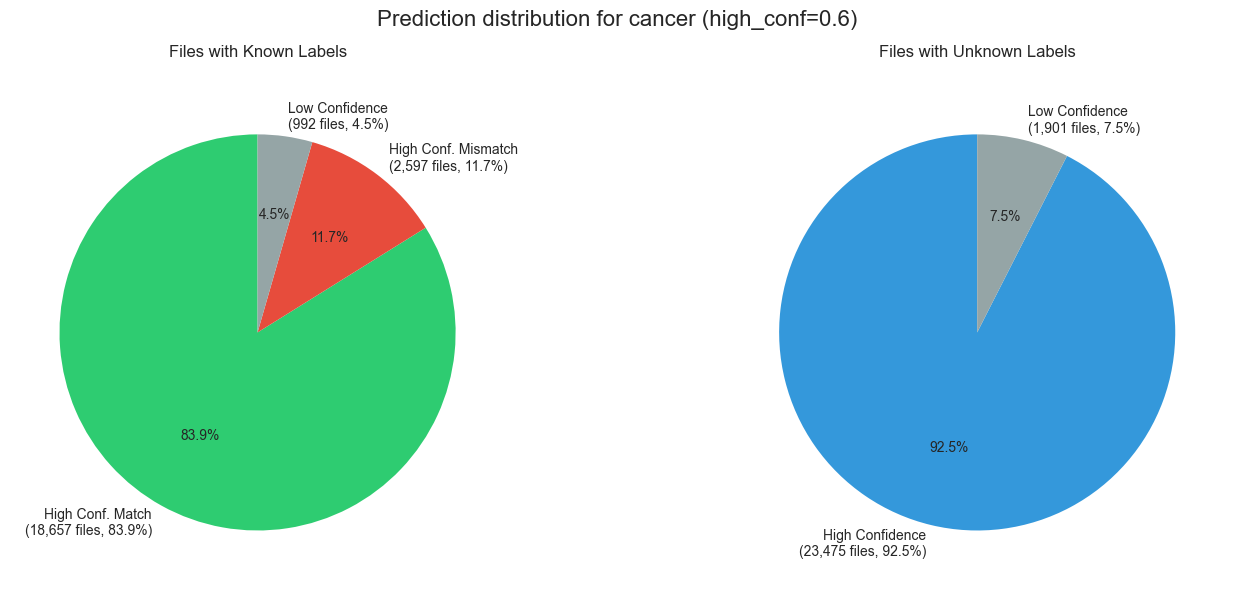

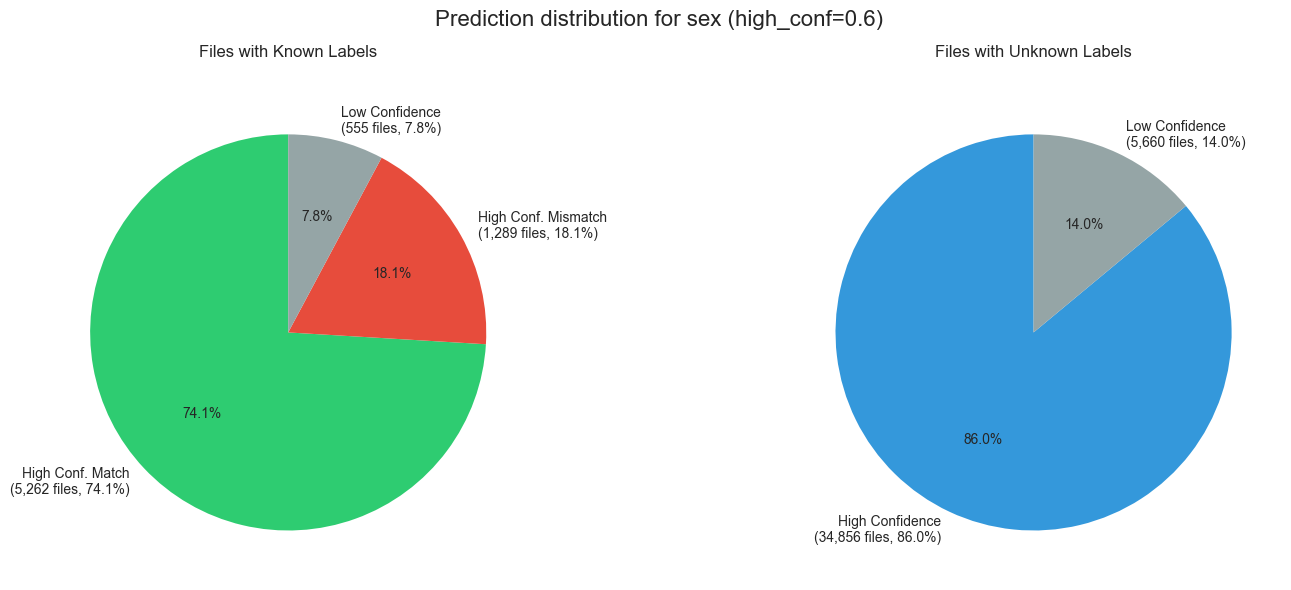

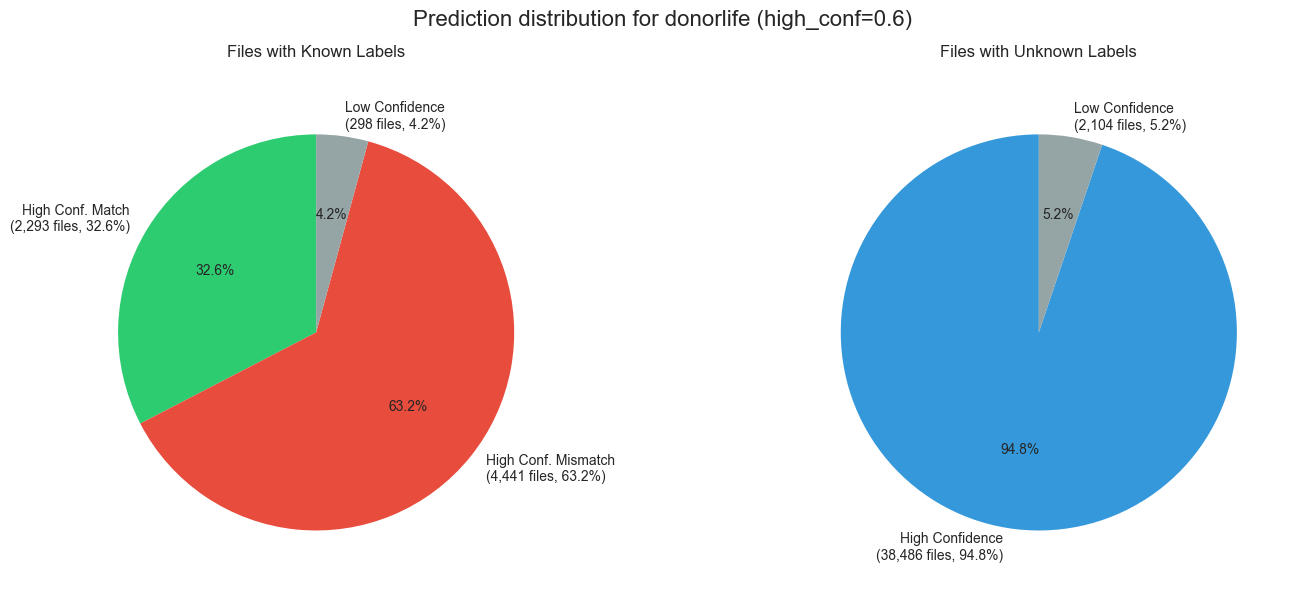

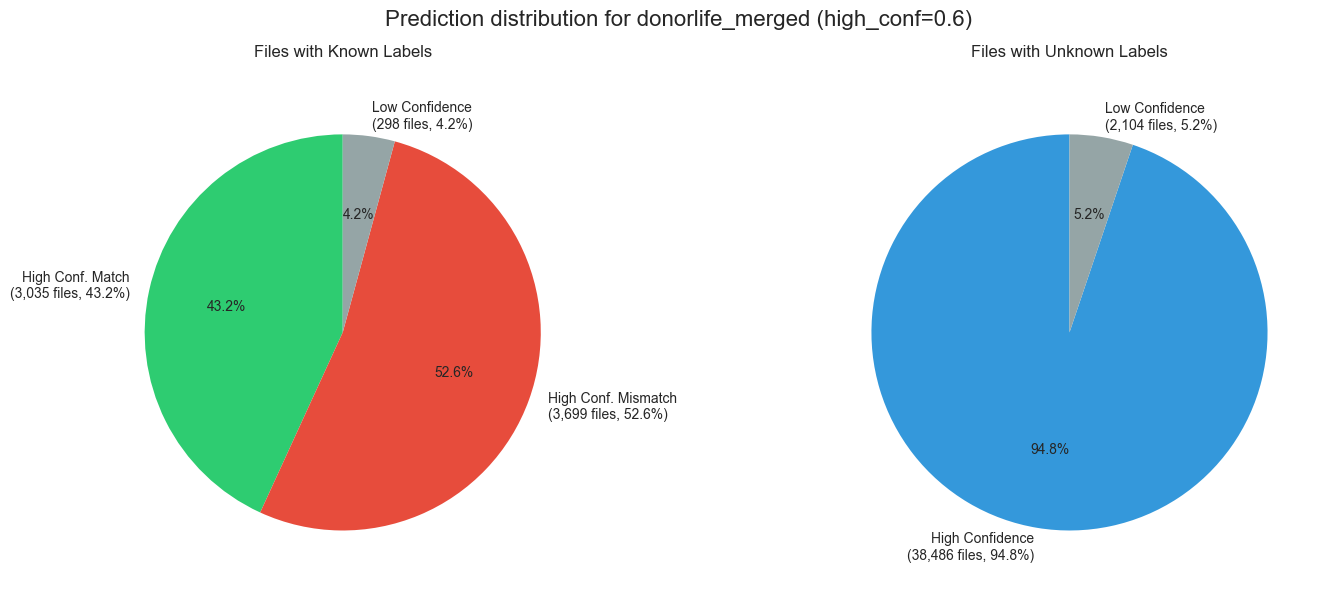

In [119]:
summary_df = create_summary_table(
    ca_preds_df_no_epiatlas, chip_atlas_cols_format, chip_atlas_categories
)
this_logdir = base_fig_dir / "chip_atlas_predictions" / "pie_charts_no_epiatlas"
this_logdir.mkdir(parents=False, exist_ok=True)
# create_pie_charts_from_summary(summary_df, this_logdir)
create_pie_charts_from_summary(summary_df, show_plot=True)

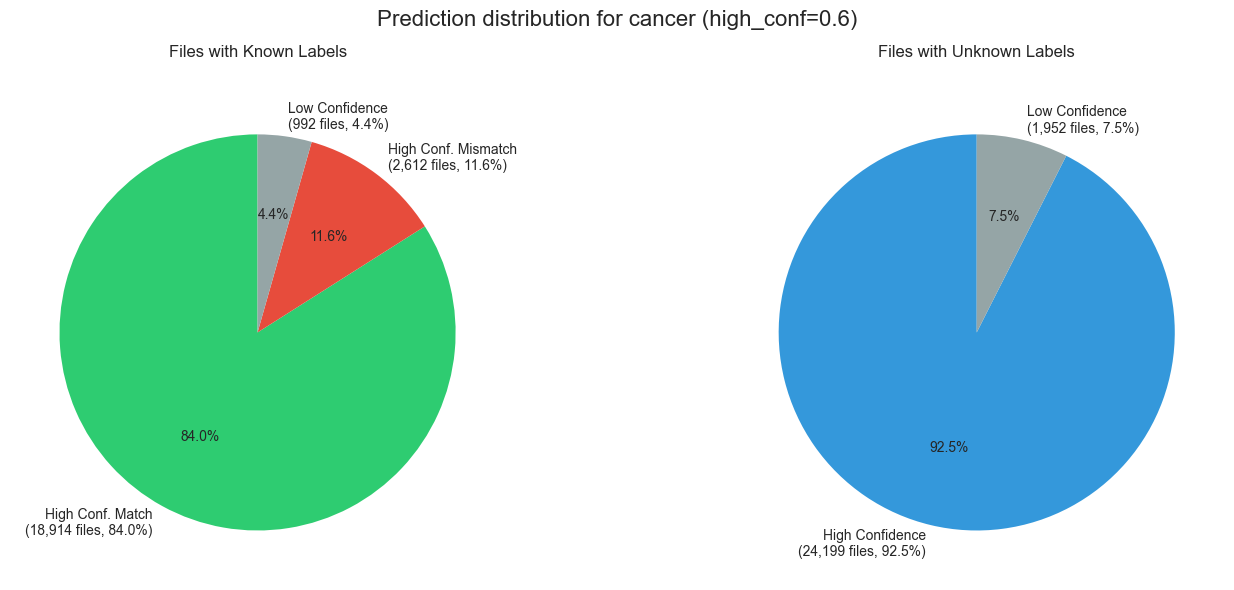

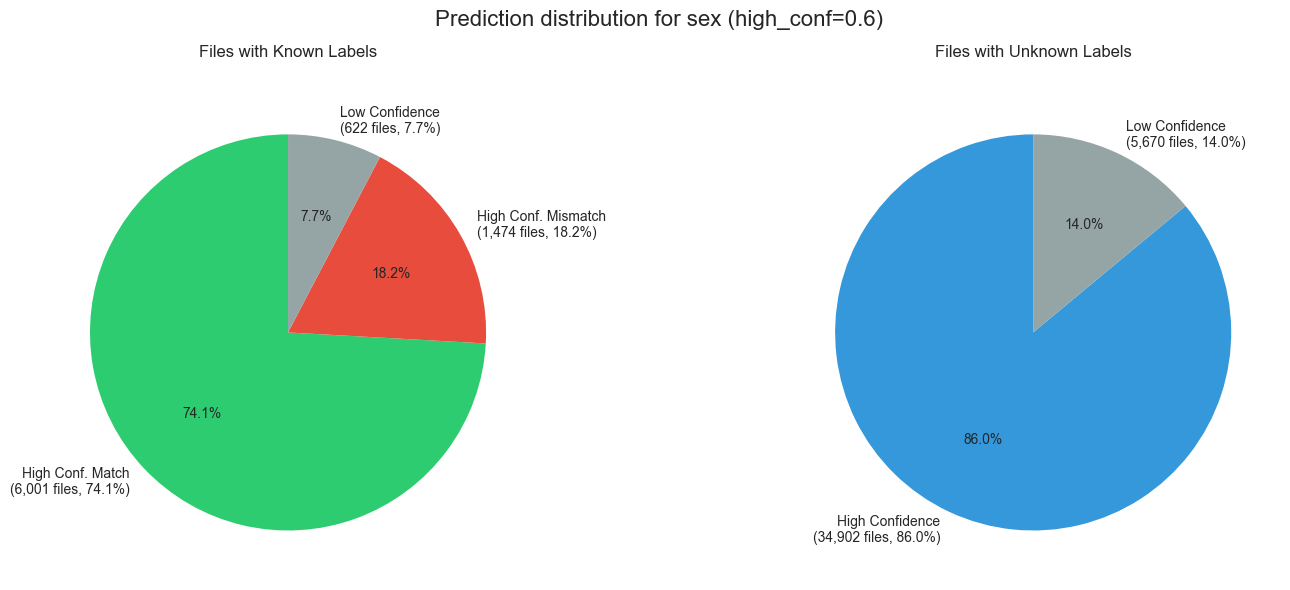

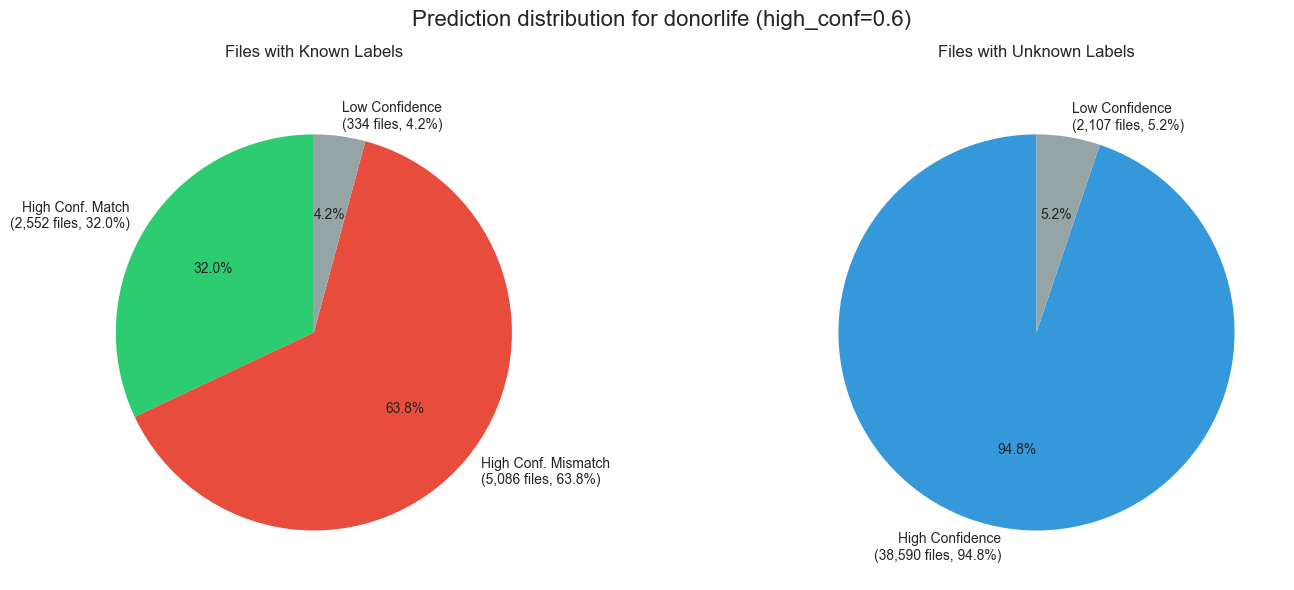

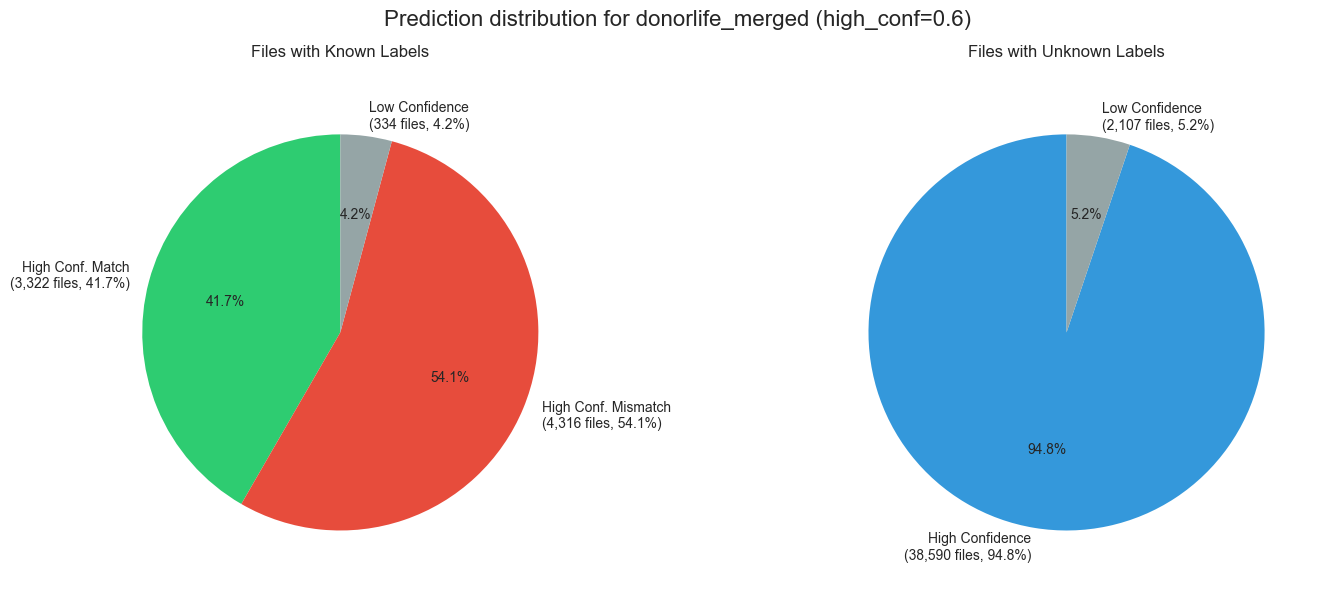

In [120]:
# with epiatlas, `(ca_preds_df["is_EpiAtlas_EpiRR"] != "0").sum()`` more files
summary_df = create_summary_table(
    ca_preds_df, chip_atlas_cols_format, chip_atlas_categories
)
this_logdir = base_fig_dir / "chip_atlas_predictions" / "pie_charts_with_epiatlas"
this_logdir.mkdir(parents=False, exist_ok=True)
# create_pie_charts_from_summary(summary_df, this_logdir)
create_pie_charts_from_summary(summary_df, show_plot=True)

### Fig ?? - recount3 dataset predictions

In [55]:
recount3_folder = (
    base_data_dir
    / "training_results"
    / "predictions"
    / "recount3"
    / "hg38_100kb_all_none"
)
if not recount3_folder.exists():
    raise FileNotFoundError()

In [77]:
meta_name = "harmonized_metadata_20250122_leuk2"
preds_path = recount3_folder / f"recount3_merged_preds_{meta_name}.tsv.gz"
recount3_df = pd.read_csv(preds_path, sep="\t")
print(f"Recount3: {recount3_df.shape[0]} files")

Recount3: 316228 files


In [78]:
column_names_template_dict = {
    "true": "Expected class ({})",
    "pred": "Predicted class ({})",
    "score": "Max pred ({})",
}

In [58]:
recount3_df = merge_life_stages(
    df=recount3_df,
    column_name_templates=list(column_names_template_dict.values()),
)

Only considering files that are confirmed as RNA for predictions of other metadata categories, i.e. (minPredScore assay classifier > 0.6 & pred = RNA)

In [80]:
recount3_df_high_conf_rna = recount3_df[
    (recount3_df[f"Max pred ({ASSAY})"] > 0.6)
    & (recount3_df[f"Predicted class ({ASSAY})"].isin(["rna_seq", "mrna_seq"]))
]
print(f"Recount3 (high_conf_rna): {recount3_df_high_conf_rna.shape[0]} files")

Recount3 (high_conf_rna): 238036 files


In [126]:
summary_df = create_summary_table(
    pred_df=recount3_df,
    relevant_cols_format=column_names_template_dict,
    categories=[CANCER, SEX, LIFE_STAGE, f"{LIFE_STAGE}_merged"],
)

summary_df_high_conf_rna = create_summary_table(
    pred_df=recount3_df_high_conf_rna,
    relevant_cols_format=column_names_template_dict,
    categories=[CANCER, SEX, LIFE_STAGE, f"{LIFE_STAGE}_merged"],
)

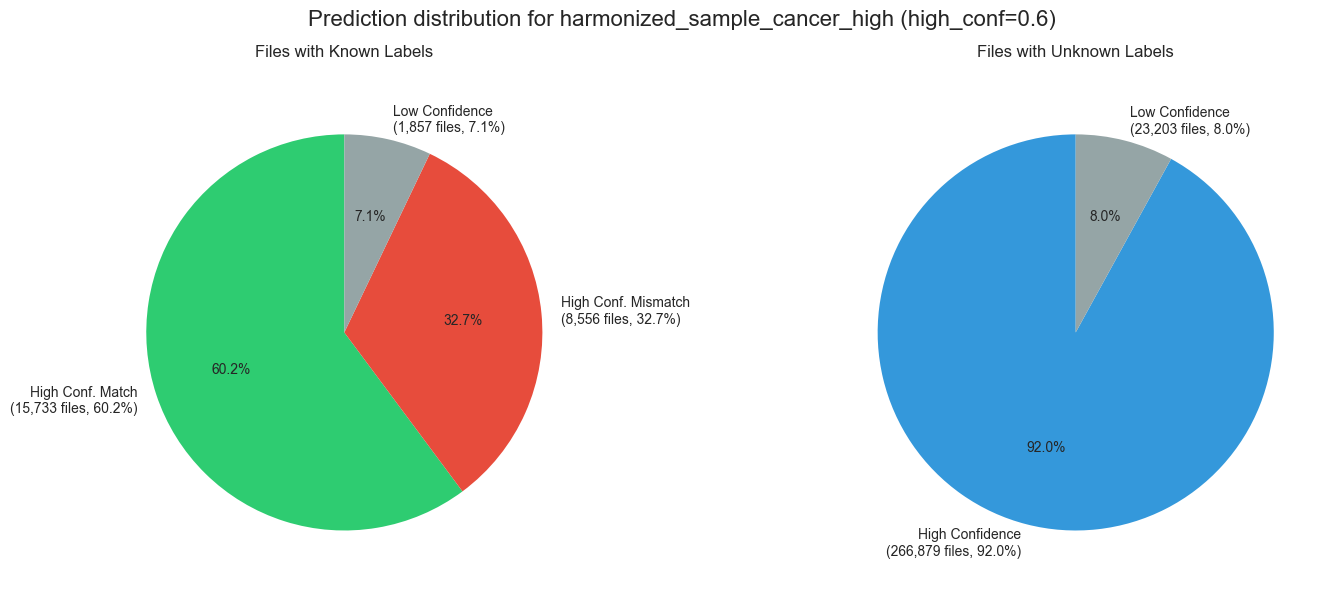

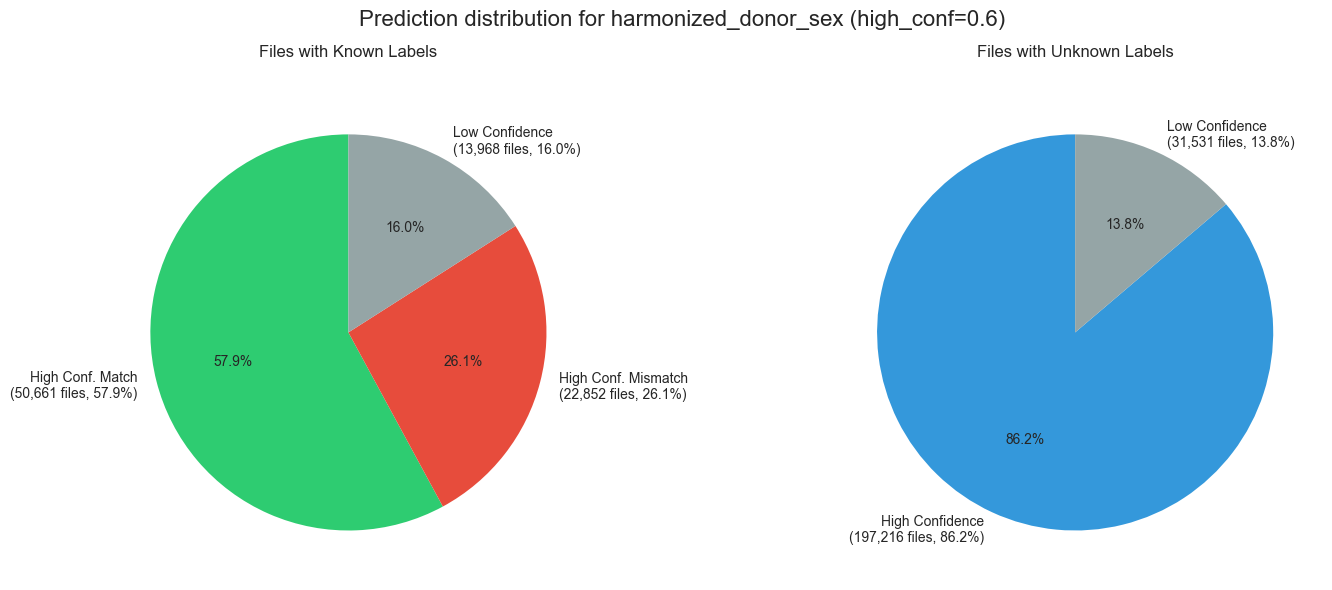

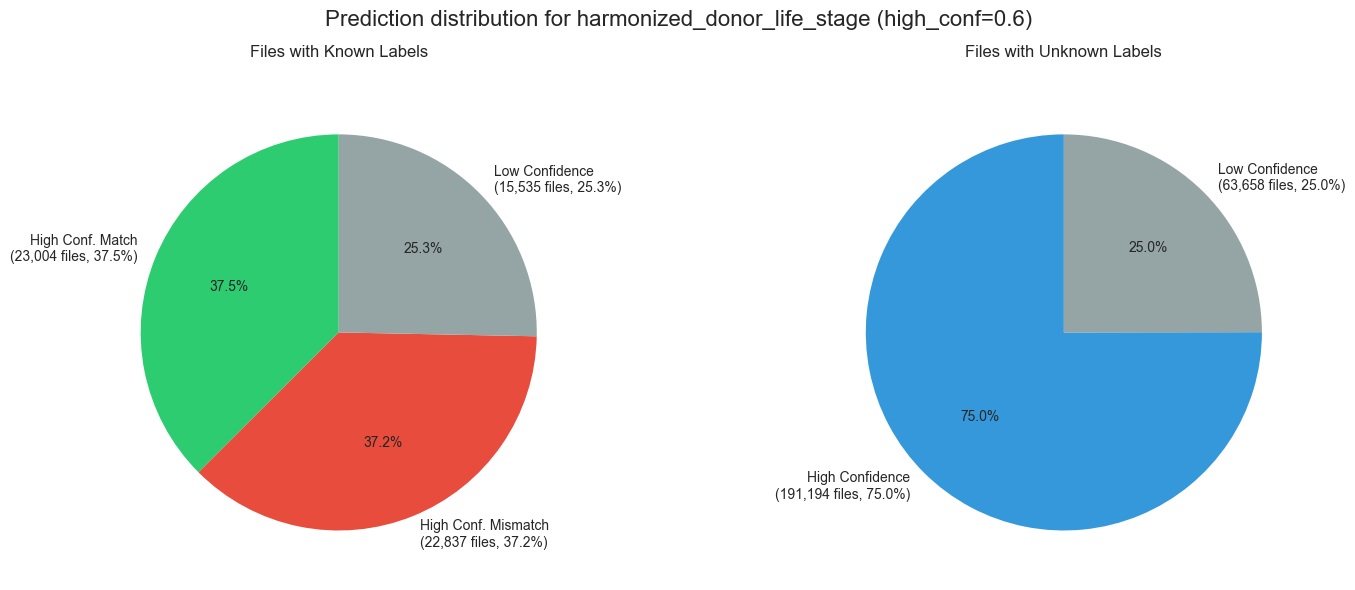

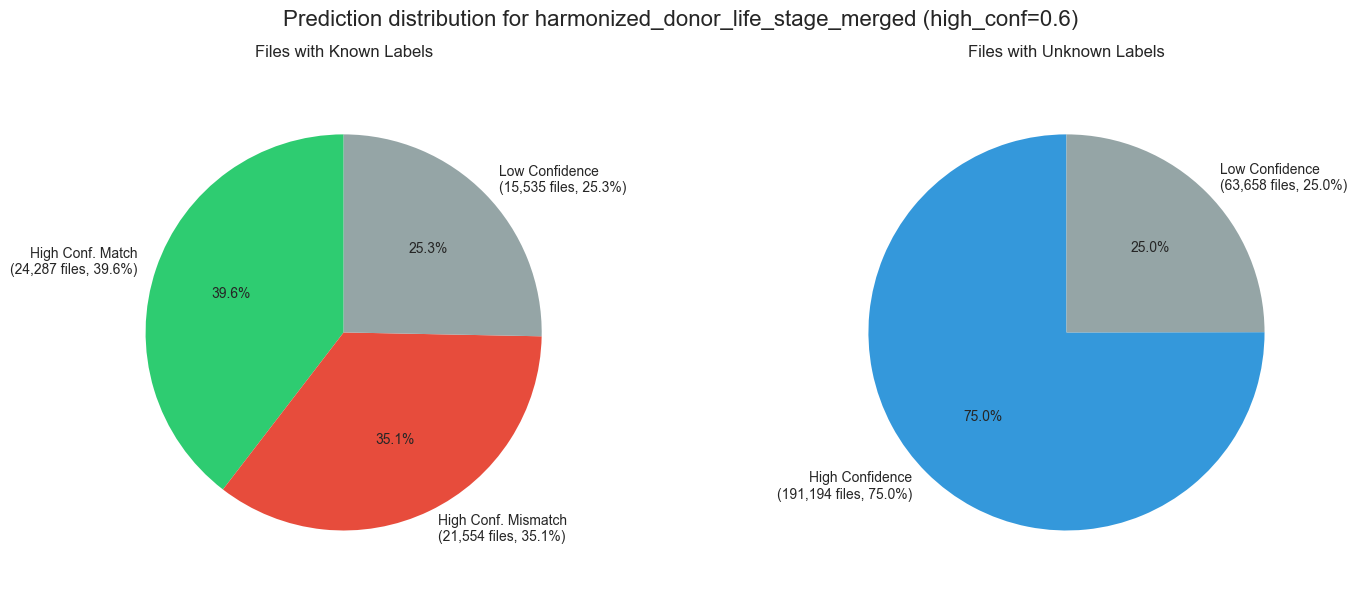

In [78]:
logdir = base_fig_dir / "recount3_predictions"
logdir.mkdir(exist_ok=True)
# create_pie_charts_from_summary(summary_df, logdir, name="all_files", show_plot=False)
# create_pie_charts_from_summary(summary_df_high_conf_rna, logdir, name="high_conf_rna", show_plot=False)
create_pie_charts_from_summary(summary_df, show_plot=True)

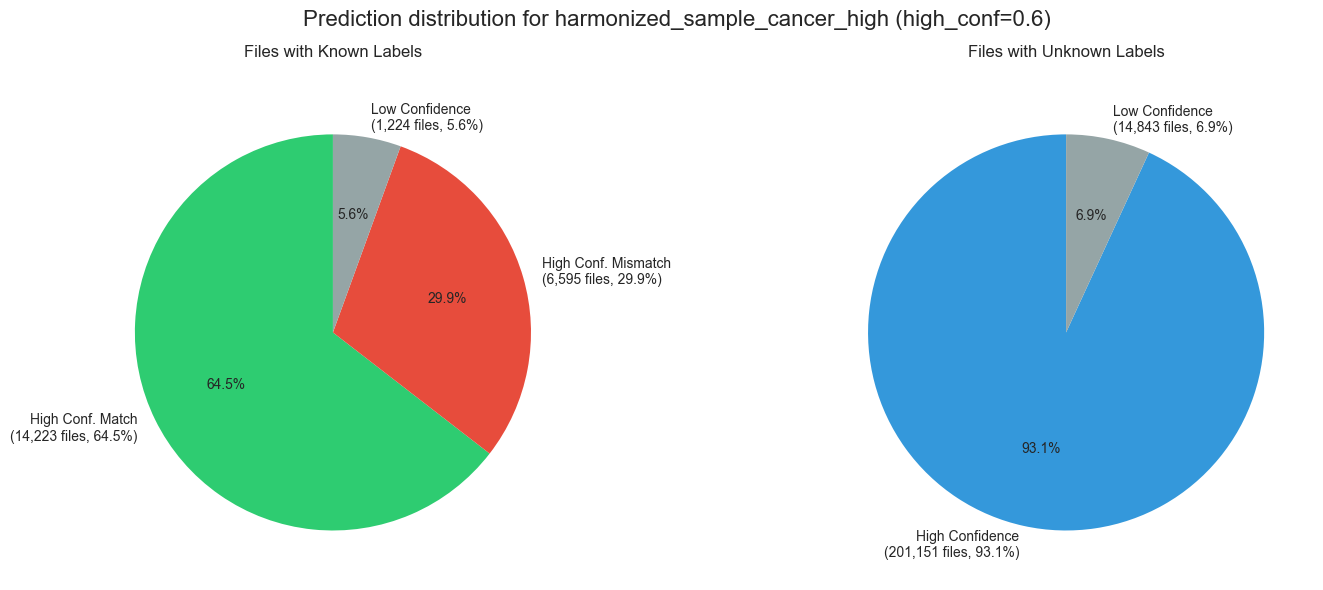

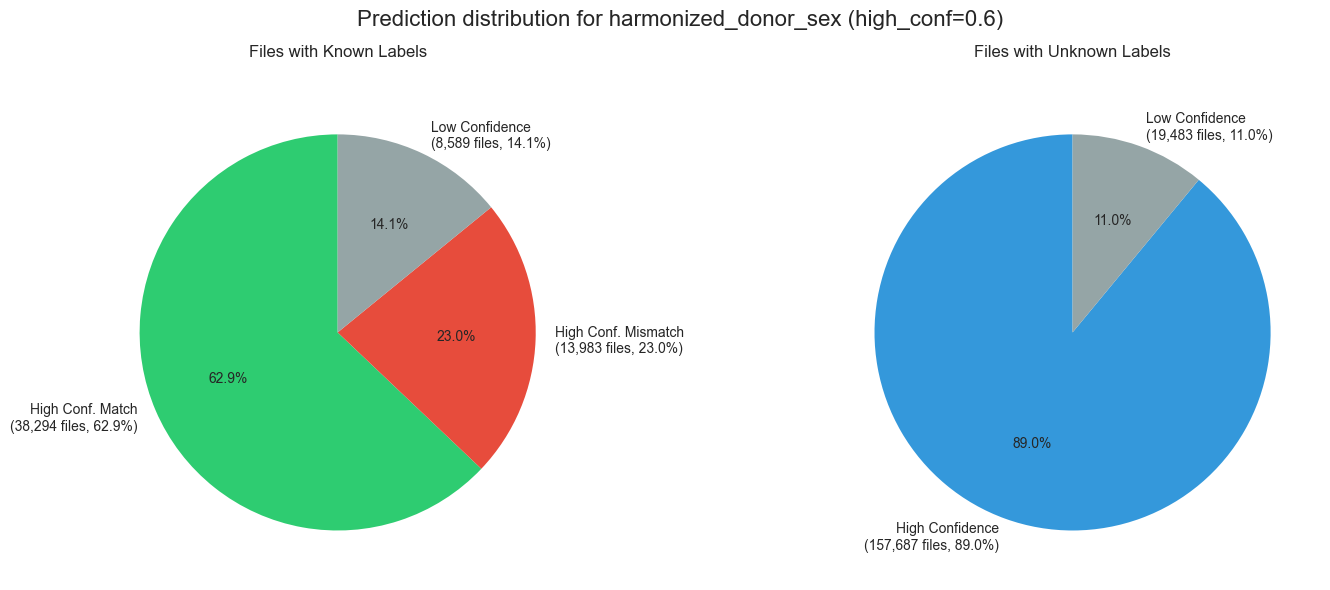

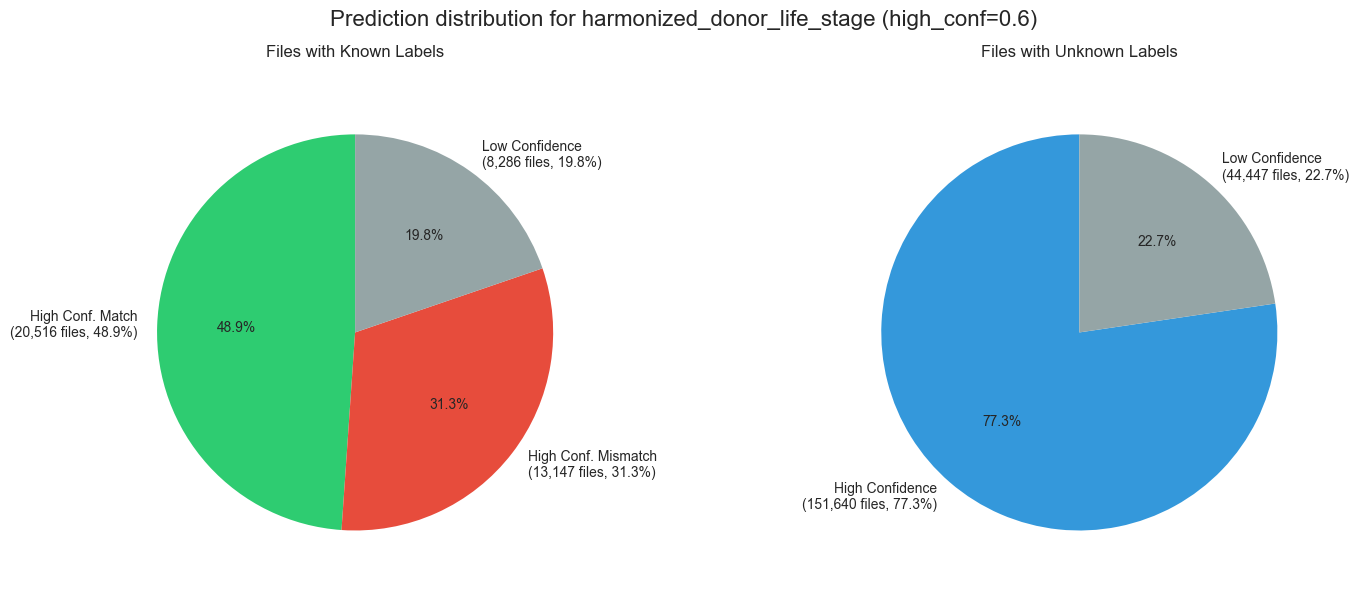

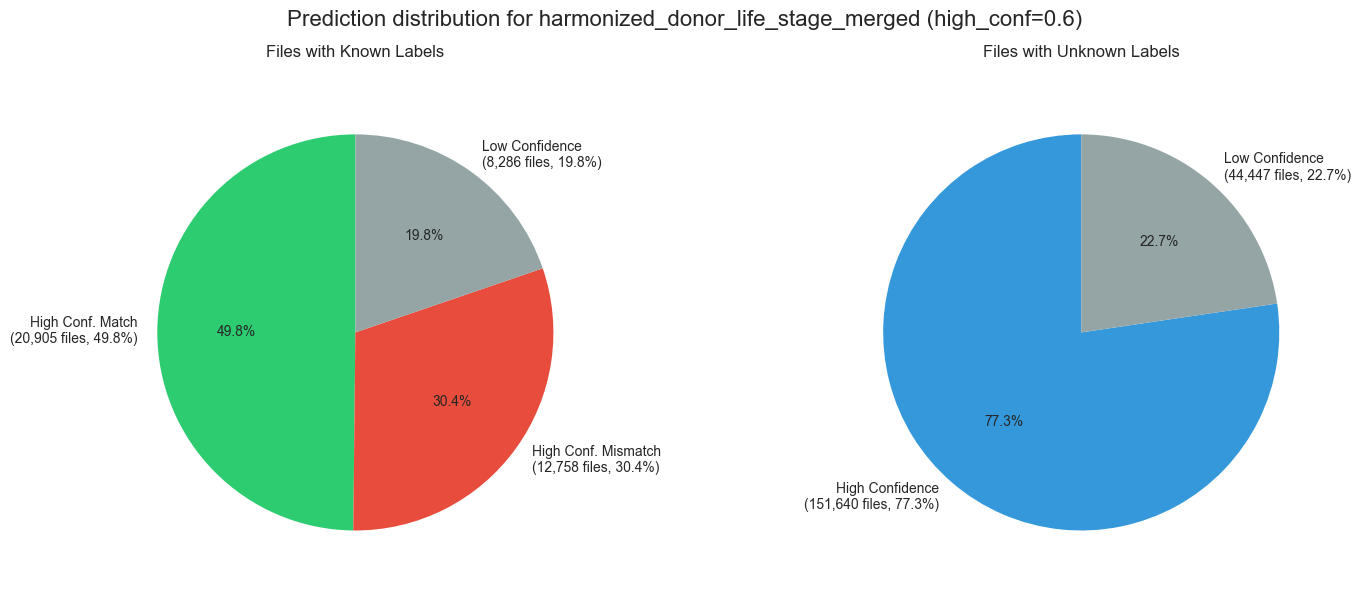

In [89]:
create_pie_charts_from_summary(summary_df_high_conf_rna, show_plot=True)

### Fig 3E - ENCODE dataset core predictions (5 tasks)

See `src/python/epi_ml/utils/notebooks/paper/encode_pred_analysis.ipynb` at section `Accuracies per assay` (plot_encode_metrics_per_assay)

### Fig 3B' - ENCODE core predictions, pie charts

In [97]:
encode_core_df = encode_preds_df[
    encode_preds_df[ASSAY].isin(CORE_ASSAYS + ["mrna_seq", "rna_seq"])
].copy()
print(f"ENCODE: {encode_core_df.shape[0]} core files")

column_names_template_dict = {
    "true": "True class ({})",
    "pred": "Predicted class ({})",
    "score": "Max pred ({})",
}

encode_core_df = merge_life_stages(
    df=encode_core_df,
    column_name_templates=list(column_names_template_dict.values()),
)

summary_df = create_summary_table(
    pred_df=encode_core_df,
    relevant_cols_format=column_names_template_dict,
    categories=[CANCER, SEX, LIFE_STAGE, f"{LIFE_STAGE}_merged"],
)

ENCODE: 4618 core files


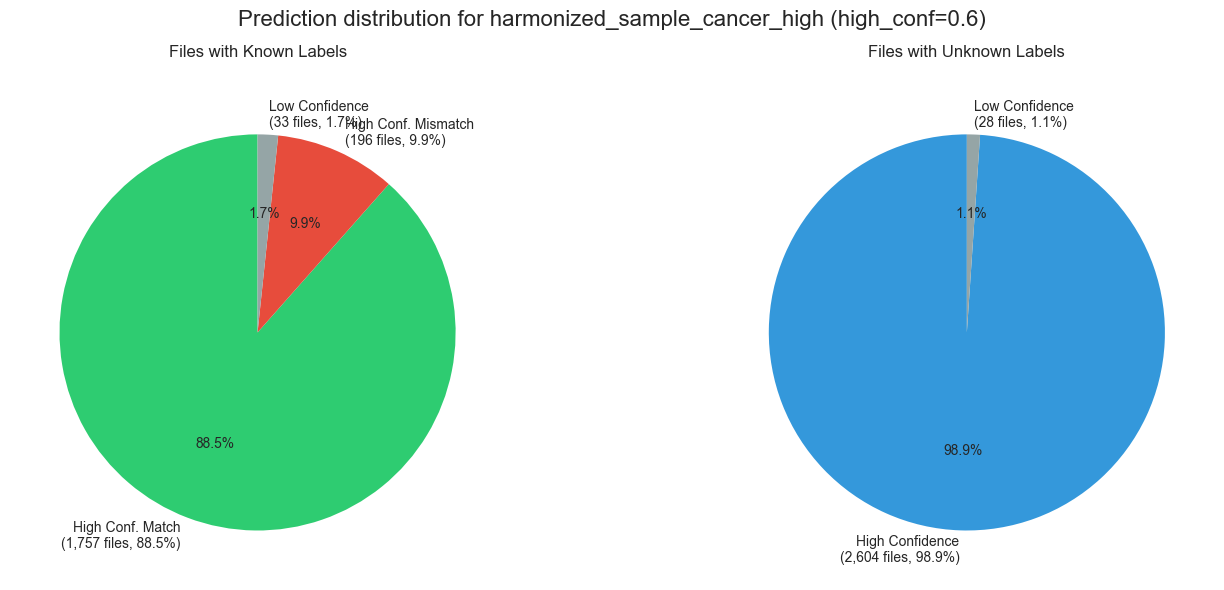

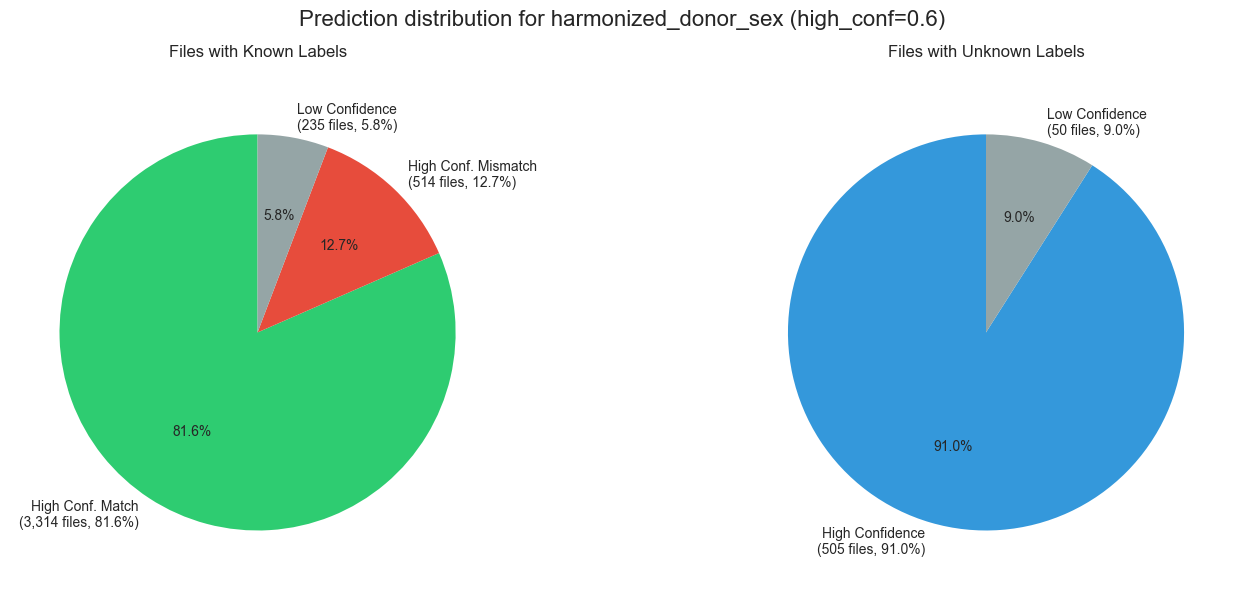

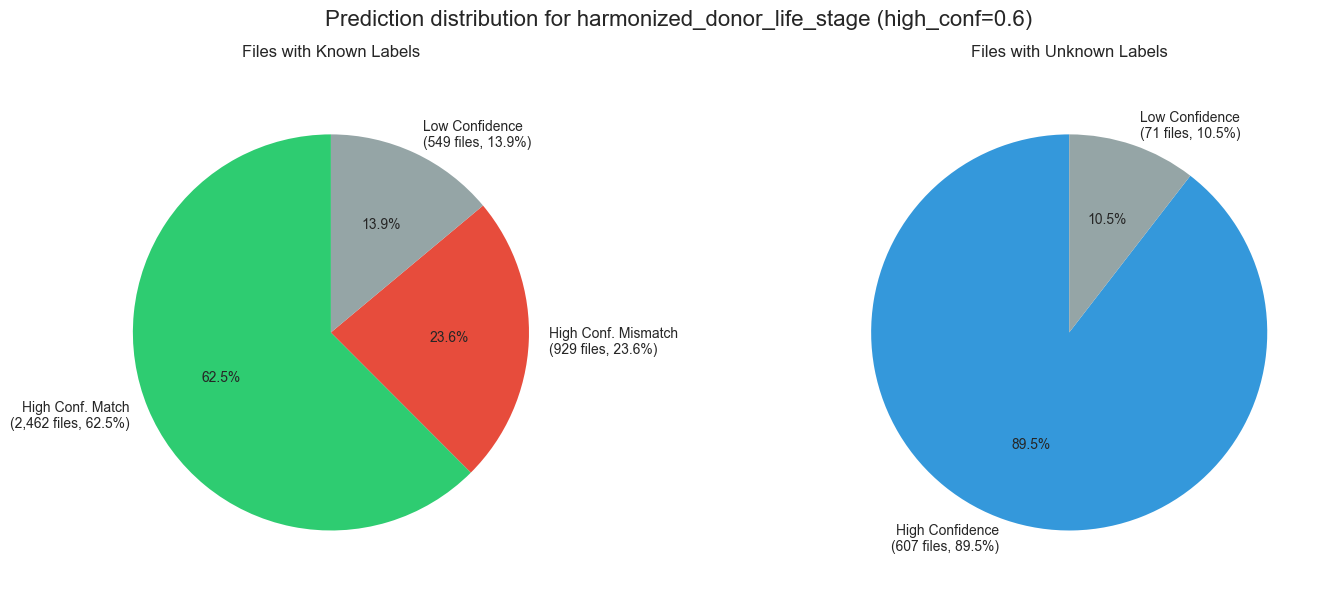

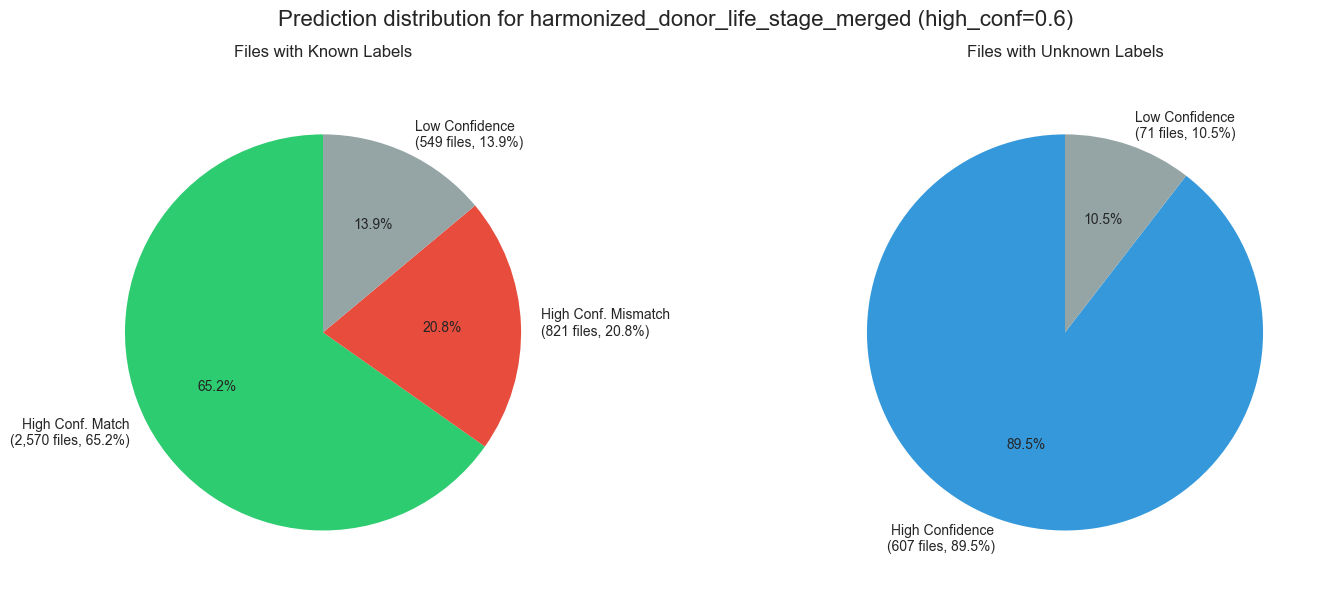

In [98]:
logdir = base_fig_dir / "encode_predictions" / "pie_charts"
logdir.mkdir(exist_ok=True)
# create_pie_charts_from_summary(summary_df, logdir)
create_pie_charts_from_summary(summary_df, show_plot=True)

### Fig 3F - ENCODE non-core predictions with assay category mapping

In [61]:
non_core_categories_path = (
    encode_meta_dir / "non-core_encode_assay_category_2024-08-29.csv"
)

non_core_categories_df = pd.read_csv(non_core_categories_path, sep=",", low_memory=False)
non_core_map = non_core_categories_df.set_index("target").to_dict()["Assay category"]
del non_core_categories_df

In [62]:
encode_non_core_df = encode_preds_df[
    encode_preds_df[ASSAY].isin(["non-core", "ctcf"])
].copy()

# Map assays to categories
encode_non_core_df["assay_category"] = (
    encode_non_core_df["assay"].str.lower().replace(non_core_map)
)

In [63]:
assay_categories_order = [
    "trx_reg",
    "heterochrom",
    "polycomb",
    "splicing",
    "insulator",
    "other/mixed",
    "not_looked",
]

assay_epiclass_order = [
    "h3k27ac",
    "h3k4me3",
    "h3k4me1",
    "h3k9me3",
    "h3k27me3",
    "h3k36me3",
    "input",
]
assay_epiclass_order = {assay: i for i, assay in enumerate(assay_epiclass_order)}
pred_col = f"Predicted class ({ASSAY})"


for min_pred in [0, 0.6]:
    sub_df = encode_non_core_df[encode_non_core_df[f"Max pred ({ASSAY})"] >= min_pred]
    groupby = (
        sub_df.groupby(["assay_category", pred_col])
        .size()
        .reset_index(name="Count")
        .sort_values(["assay_category", "Count"], ascending=[True, False])
    )
    groupby["Percentage"] = groupby.groupby("assay_category")["Count"].transform(
        lambda x: (x / x.sum()) * 100
    )

    # Add order for plotting
    groupby["assay_order"] = groupby[pred_col].map(assay_epiclass_order)
    groupby = groupby.sort_values(
        ["assay_category", "assay_order"], ascending=[False, True]
    )

    # Main plot
    fig = px.bar(
        groupby,
        x="assay_category",
        y="Percentage",
        color=pred_col,
        barmode="stack",
        category_orders={"assay_category": assay_categories_order},
        color_discrete_map=assay_colors,
        title=f"core7 predictions for non-core assays, predScore >= {min_pred:.2f}",
        labels={"Percentage": "Percentage (%)", "assay_category": "Assay Category"},
    )

    # Modify x-axis labels
    total_counts = groupby.groupby("assay_category")["Count"].sum()
    ticktext = [
        f"{assay_category} (N={total_counts[assay_category]})"
        for assay_category in assay_categories_order
    ]
    fig.update_xaxes(tickvals=assay_categories_order, ticktext=ticktext)
    fig.show()

## Supp Fig 5A - UpsetPlot of assay labels provided in 4 DBs

In [64]:
for col in ca_core7_df.columns:
    if "consensus" in col:
        print(col)

core7_DBs_consensus
manual_target_consensus


In [65]:
consensus_col = "core7_DBs_consensus"

In [66]:
def create_4DB_consensus_description(ca_core_df: pd.DataFrame) -> pd.Series:
    """Create a description of the 4DB assay consensus labels.

    Treat "Unclassified" from Chip-Atlas as absent samples for the target consensus evaluation.

    The consensus description is based on the following rules:
    - "Identical" if all labels are the same
    - "Different" if at least one label is different
    - "1 source" if only one DB has a label
    - "Ignored - Potential non-core" if any label is not in the core assays

    Args:
        ca_core_df: ChIP-Atlas core7 DataFrame

    Returns:
        Series with the target consensus description
    """
    id_db_target = []
    tmp_df = ca_core_df.loc[:, DB_COLS].copy()
    tmp_df["C-A"].replace("unclassified", "----", inplace=True)

    for labels in tmp_df.values:
        missing_N = sum(label == "----" for label in labels)
        db_labels = set(labels)

        try:
            db_labels.remove("----")
        except KeyError:
            pass
        if any(label not in CORE_ASSAYS + ["ctrl"] for label in db_labels):
            id_db_target.append("Ignored - Potential non-core")
        elif missing_N == 3:
            id_db_target.append("1 source")
        elif len(db_labels) == 1:
            id_db_target.append("Identical")
        else:
            id_db_target.append("Different")

    return pd.Series(id_db_target, index=ca_core_df.index)

In [67]:
def make_db_upsetplot(
    df: pd.DataFrame, consensus_col: str, db_cols: List[str], title: str
) -> upsetplot.UpSet:
    """Make an upsetplot of the sample presence in the different databases."""
    df = df.copy()

    # Create a new DataFrame with boolean columns for each database
    upset_df = pd.DataFrame()
    for col in db_cols:
        upset_df[col] = df[col] != "----"
    upset_df[consensus_col] = df[consensus_col]

    # Set the index for the UpSet plot
    upset_df = upset_df.set_index(db_cols)

    # Create the UpSet plot
    upset = upsetplot.UpSet(
        upset_df,
        intersection_plot_elements=0,  # disable the default bar chart
        sort_by="cardinality",
        show_counts=True,  # type: ignore
        orientation="horizontal",
    )

    # Add stacked bars
    upset.add_stacked_bars(by=consensus_col, elements=15)

    # Plot and set title
    axes = upset.plot()
    plt.suptitle(title)
    axes["totals"].set_title("Total")
    plt.legend(loc="center left")
    return upset

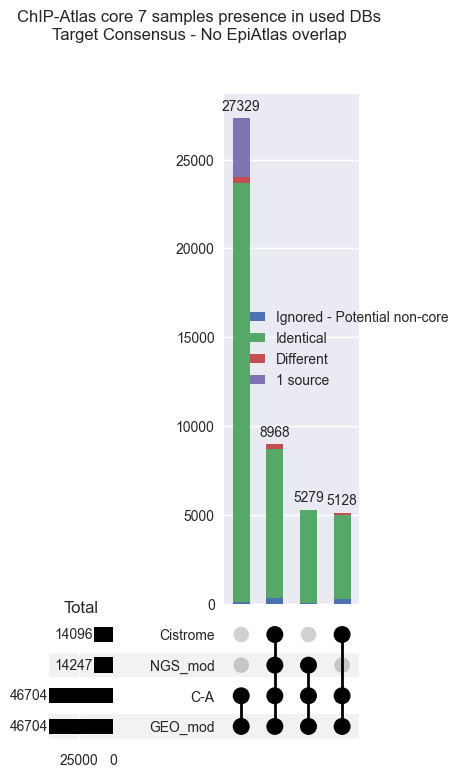

In [68]:
title = "ChIP-Atlas core 7 samples presence in used DBs\nTarget Consensus - No EpiAtlas overlap"
upset = make_db_upsetplot(
    df=ca_core7_df, consensus_col=consensus_col, db_cols=DB_COLS, title=title
)
plt.show()

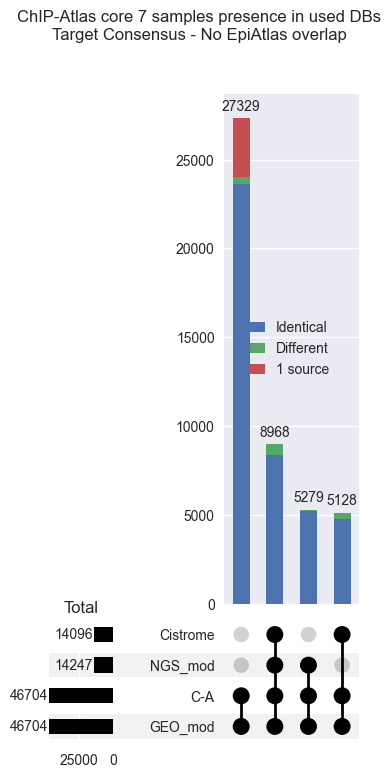

In [69]:
title = "ChIP-Atlas core 7 samples presence in used DBs\nTarget Consensus - No EpiAtlas overlap"
new_df = ca_core7_df.copy()
new_df[consensus_col].replace("Ignored - Potential non-core", "Different", inplace=True)
upset = make_db_upsetplot(
    df=new_df, consensus_col=consensus_col, db_cols=DB_COLS, title=title
)

# fig_dir = base_fig_dir / "fig_C-A" / "DB_upset"
# plt.savefig(fig_dir / "upsetplot_DB_core7_samples_noEpiAtlas_merge_different.svg", bbox_inches="tight")